<a href="https://colab.research.google.com/github/guptaru1/StockPrediction/blob/main/StockPredictionUsingLSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

new features


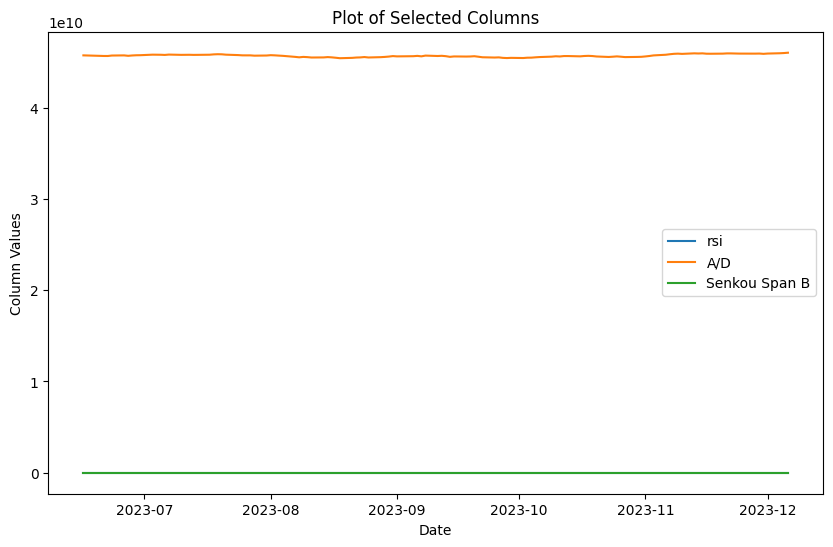

            actualclose  Target       close       volume        open  \
2023-06-16   184.919998       0  186.009995   65433200.0  183.960007   
2023-06-20   185.009995       1  184.919998  101235600.0  186.729996   
2023-06-21   183.960007       0  185.009995   49799100.0  184.410004   
2023-06-22   187.000000       1  183.960007   49515700.0  184.899994   
2023-06-23   186.679993       0  187.000000   51245300.0  183.740005   

                  high         low     200day       50day       dif  ...  \
2023-06-16  186.520004  183.779999  153.05285  171.960201  4.057628  ...   
2023-06-20  186.990005  184.270004  153.18290  172.383401  4.259871  ...   
2023-06-21  186.100006  184.410004  153.32185  172.790400  4.236794  ...   
2023-06-22  185.410004  182.589996  153.45185  173.229001  4.049551  ...   
2023-06-23  187.050003  183.669998  153.60780  173.753000  4.093654  ...   

                 CCI           A/D           udl           fsl  Tenkan-sen  \
2023-06-16  8.688963  4.574852e+

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


try:
    import yahoo_fin.stock_info as si
except ModuleNotFoundError:
    if 'google.colab' in str(get_ipython()):
        !pip install yahoo_fin
    import yahoo_fin.stock_info as si
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
mutation_prob = 0.2
crossover_prob = 0.8
initial_population = 100
generations = 150
rsi_threshold = 30
ema_weight = 0.8


def pre_process(stock_data):
  data = stock_data[["close"]]
  data = data.rename(columns= {'close': 'actualclose'})
  #this is so that we can see which is higer or above in the stock
  #data["Target"] = stock_data.rolling(2).apply(lambda x: x.iloc[1] > x.iloc[0])["Actual_Close"]
  data['Target'] = (data['actualclose'] > data['actualclose'].shift(1)).astype(int)
  stock_data_copy = stock_data.copy()
  stock_data_shifted = stock_data_copy.shift(1)

  #combine training data
  predictors = ["close", "volume", "open", "high", "low"]
  data = data.join(stock_data_shifted[predictors]).iloc[1:]

  return data


#calculate simple moving average using %d which is usually a 3 day period
def calculate_stochastic_oscillator(data, k_period=14, d_period=3):
    # Calculate %K
    data['Lowest Low'] = data['low'].rolling(window=k_period).min()
    data['Highest High'] = data['high'].rolling(window=k_period).max()
    data['%K'] = ((data['close'] - data['Lowest Low']) / (data['Highest High'] - data['Lowest Low'])) * 100
    # Calculate %D (3-period SMA of %K)
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    # Drop auxiliary columns
    data.drop(['Lowest Low', 'Highest High'], axis=1, inplace=True)
    return data[['%K', '%D']]


def calculate_features(data):
    close_prices = data['close']
    #rsi
    #rsi = talib.RSI(close_prices, timeperiod=14)
    #calcualte ema
    #sma for a 200 period
    data["200day"] = data["close"].rolling(200).mean()
    #sma for a 50 day period
    data["50day"] = data["close"].rolling(50).mean()
    print("new features")
    print(data.head(5))



def sharpe_ratio(weights, data):
  data_returns = np.log(data) - np.log(data.shift(1))
  data_returns = data_returns.dropna()

  portfolio_returns = np.dot(data_returns, weights)
  portfolio_mean = np.mean(portfolio_returns)
  portfolio_std = np.std(portfolio_returns)
  sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
  return sharpe_ratio


# Scrape stock data from Yahoo Finance

stock_data = si.get_data("AAPL")
'''
stock_data = si.download('AAPL',
                      start='2010-01-01',
                      end='2021-06-12',
                      progress=False,
)
'''
from datetime import datetime, timedelta

def calculate_stochastic_oscillator(data, k_period=14, d_period=3):
    # Calculate %K
    data['Lowest Low'] = data['low'].rolling(window=k_period).min()
    data['Highest High'] = data['high'].rolling(window=k_period).max()
    data['%K'] = ((data['close'] - data['Lowest Low']) / (data['Highest High'] - data['Lowest Low'])) * 100
    # Calculate %D (3-period SMA of %K)
    data['%D'] = data['%K'].rolling(window=d_period).mean()
    # Drop auxiliary columns
    data.drop(['Lowest Low', 'Highest High'], axis=1, inplace=True)
    return data[['%K', '%D']]


def esa(data):
    close_prices = data['close']
    #rsi
    #rsi = talib.RSI(close_prices, timeperiod=14)
    #calcualte ema
    #sma for a 200 period
    data["200day"] = data["close"].rolling(200).mean()
    #sma for a 50 day period
    data["50day"] = data["close"].rolling(50).mean()
    data["26day"] = data["close"].rolling(26).mean()
    data["12day"] = data["close"].rolling(12).mean()
    data['dif'] = data['12day'] - data['26day']
    columns_to_drop = ["26day", "12day"]

    # Calculate the rolling mean (middle band)
    # Drop the specified columns
    data.drop(columns=columns_to_drop, inplace=True)

def boilinger_band(data, window=20):
    # Calculate the rolling mean and standard deviation
    rolling_mean = data['close'].rolling(window=window).mean()
    rolling_std = data['close'].rolling(window=window).std()

    # Calculate upper and lower bands
    data["upper_band"] = rolling_mean + (rolling_std * num_std)
    data["lower_band"] = rolling_mean - (rolling_std * num_std)


def calculate_ichimoku_cloud(data, tenkan_period=9, kijun_period=26, senkou_span_b_period=52, displacement=26):
    # Calculate Tenkan-sen
    data['Tenkan-sen'] = (data['high'].rolling(window=tenkan_period).max() + data['low'].rolling(window=tenkan_period).min()) / 2

    # Calculate Kijun-sen
    data['Kijun-sen'] = (data['high'].rolling(window=kijun_period).max() + data['low'].rolling(window=kijun_period).min()) / 2

    # Calculate Senkou Span A
    data['Senkou Span A'] = ((data['Tenkan-sen'] + data['Kijun-sen']) / 2).shift(displacement)

    # Calculate Senkou Span B
    data['Senkou Span B'] = ((data['high'].rolling(window=senkou_span_b_period).max() + data['low'].rolling(window=senkou_span_b_period).min()) / 2).shift(displacement)


def cal_fsl_udl(data):
  data['price_change'] = data['close'].diff()

  # Calculate Upside and Downside Volumes
  data['upside_volume'] = data['volume'].where(data['price_change'] > 0, 0)
  data['downside_volume'] = data['volume'].where(data['price_change'] < 0, 0)

  # Calculate Upside Downside Line (UDL)
  data['udl'] = data['upside_volume'].cumsum() - data['downside_volume'].cumsum()

  # Calculate Force Index (FSL)
  data['fsl'] = data['price_change'] * data['volume']

  columns_to_drop = ["price_change" , "upside_volume", "downside_volume"]
  data.drop(columns = columns_to_drop, inplace=True)


def calculate_rsi(data, period=14):
    # Calculate price changes
    delta = data['close'].diff(1)

    # Calculate gain (positive price changes) and loss (negative price changes)
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)

    # Calculate average gain and average loss over the specified period
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()

    # Calculate relative strength (RS)
    rs = avg_gain / avg_loss

    # Calculate RSI
    rsi = 100 - (100 / (1 + rs))

    data["rsi"] = rsi

def accumulate_distribution(df):
    df['A/D'] = (df['close'] - df['low'] - (df['high'] - df['close'])) / (df['high'] - df['low']) * df['volume']
    df['A/D'] = df['A/D'].cumsum()  # Cumulative sum to get the Accumulation/Distribution line


def CCI(df):
  # Calculate Typical Price (TP)
  df['TP'] = (df['high'] + df['low'] + df['close']) / 3
  # Calculate 10-period Simple Moving Average (SMA) of Typical Prices
  df['SMA10'] = df['TP'].rolling(window=10).mean()
  # Calculate Mean Deviation (MD)
  df['MD'] = df['TP'] - df['SMA10']
  df['MD'] = df['MD'].abs().rolling(window=10).sum()
  # Calculate Commodity Channel Index (CCI)
  factor = 0.015
  df['CCI'] = (df['TP'] - df['SMA10']) / (factor * df['MD'])
  # Drop intermediate columns (TP, SMA10, MD)
  df.drop(['TP', 'SMA10', 'MD'], axis=1, inplace=True)


def sharpe_ratio(weights, data):
  data_returns = np.log(data) - np.log(data.shift(1))
  data_returns = data_returns.dropna()

  portfolio_returns = np.dot(data_returns, weights)
  portfolio_mean = np.mean(portfolio_returns)
  portfolio_std = np.std(portfolio_returns)
  sharpe_ratio = (portfolio_mean / portfolio_std) * np.sqrt(252)
  return sharpe_ratio


def calculate_features(processed_data, feature_functions):
  for func in feature_functions:
        func(processed_data)
  return processed_data

def calculate_adx(data, period=14):
    # Calculate True Range (TR)
    data['High-Low'] = data['high'] - data['low']
    data['High-PrevClose'] = abs(data['high'] - data['close'].shift(1))
    data['Low-PrevClose'] = abs(data['low'] - data['close'].shift(1))
    data['TR'] = data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)

    # Calculate +DM and -DM
    data['UpMove'] = data['high'].diff()
    data['DownMove'] = -data['low'].diff()
    data['+DM'] = data['UpMove'].where((data['UpMove'] > data['DownMove']) & (data['UpMove'] > 0), 0)
    data['-DM'] = data['DownMove'].where((data['DownMove'] > data['UpMove']) & (data['DownMove'] > 0), 0)

    # Smoothed TR, +DM, and -DM
    data['ATR'] = data['TR'].ewm(span=period, adjust=False).mean()
    data['+DM_Smoothed'] = data['+DM'].ewm(span=period, adjust=False).mean()
    data['-DM_Smoothed'] = data['-DM'].ewm(span=period, adjust=False).mean()

    # Calculate +DI and -DI
    data['+DI'] = (data['+DM_Smoothed'] / data['ATR']) * 100
    data['-DI'] = (data['-DM_Smoothed'] / data['ATR']) * 100

    # Calculate DX
    data['DX'] = (abs(data['+DI'] - data['-DI']) / (data['+DI'] + data['-DI'])) * 100

    # Calculate ADX
    data['ADX'] = data['DX'].ewm(span=period, adjust=False).mean()

    # Drop intermediate columns
    data.drop(['High-Low', 'High-PrevClose', 'Low-PrevClose', 'UpMove', 'DownMove', '+DM', '-DM', 'ATR', '+DM_Smoothed', '-DM_Smoothed', '+DI', '-DI', 'DX'], axis=1, inplace=True)




processed_data = pre_process(stock_data)
feature_functions = [esa, calculate_stochastic_oscillator, calculate_rsi, CCI, accumulate_distribution, cal_fsl_udl, calculate_ichimoku_cloud, calculate_adx]
processed_data = calculate_features(processed_data, feature_functions)
#calculate_features(processed_data)
print("new features")
processed_data  = processed_data.dropna()
#getting data to train from 1982-12-06 till 2023-11-29
X_selected = processed_data.iloc[10490:]
columns_to_plot = ['rsi', 'A/D', 'Senkou Span B']

testing_data_set = processed_data.iloc[10000:10100]

# Plot the selected columns
plt.figure(figsize=(10, 6))
for column in columns_to_plot:
    plt.plot(X_selected.index, X_selected[column], label=column)

# Add labels and legend
plt.title('Plot of Selected Columns')
plt.xlabel('Date')
plt.ylabel('Column Values')
plt.legend()

# Show the plot
plt.show()
print(X_selected.head())
print(processed_data.head())

In [ ]:
try:
  from sklearn.model_selection import train_test_split
except:
  !pip install -U scikit-learn
  from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error
import random
import warnings
from tqdm import tqdm
import time
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
import tensorflow as tf
from tensorflow.keras.layers import LSTM, Dense
from keras.callbacks import EarlyStopping



# Filter out the specific UserWarning from scikit-learn
warnings.filterwarnings("ignore", category=UserWarning, module="sklearn.base")



class Chromosome():
  def __init__(self, num_features, gene):


      #np array
      self.genes = gene



class Population():
  def __init__(self, population_size,dataset, testing_dataset, num_features =15 ):
      #generates our initial population -> rep of 1,0 for what feature to include and what not to
      self.population = []
      self.model = None
      self.features = dataset[["200day", "50day", "rsi", "%K", "%D", "CCI", "A/D", "udl", "fsl", "TR", "ADX", "Tenkan-sen", "Kijun-sen", "Senkou Span A", "Senkou Span B", "close"]]
      self.testing = testing_dataset
      self.target_vals = dataset["Target"]

      self.max_fitness = 0
      self.num_features = num_features
      self.best_solution = None
      self.population_size = population_size
      self.gene_length = num_features
      self.init_pop()
      self.feature_tracker = {}


  #generate init population
  def init_pop(self):
      seed_counter = 0
      for i in range(self.population_size):
            # Use a unique seed for each chromosome
            seed = int(time.time()) + seed_counter
            np.random.seed(seed)

            self.population.append(Chromosome(self.num_features, np.random.randint(2, size=self.num_features)))

            # Increment the counter for the next chromosome
            seed_counter += 1

  def train_model(self, X_train, y_train, model):
    model.compile(optimizer='adam', loss='mean_squared_error')
    model.fit(X_train, y_train, epochs=20, batch_size=32)

  def lstm_model(self, dataset):
    scaler = MinMaxScaler(feature_range=(0,1))

    scaled_data = scaler.fit_transform(dataset)
    time_steps = 20

    sequences, labels = [], []
    for i in range(len(scaled_data) - time_steps):
      sequences.append(scaled_data[i: i + time_steps, :])
      labels.append(self.target_vals[i+time_steps])

    X, y = np.array(sequences), np.array(labels)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=None)

    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(LSTM(units=50, return_sequences=True))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))

    #loss = model.evaluate(X_test, y_test)
    self.train_model(X_train, y_train, model)

    predictions = model.predict(X_test)
    # Convert continuous predictions to binary predictions
    #binary_predictions = (predictions >= 0.5).astype(int)

    # Now you can use classification metrics
    from sklearn.metrics import accuracy_score, confusion_matrix



    # Assuming y_test contains your true binary labels
    threshold = 0.5
    binary_predictions = (predictions >= threshold).astype(int)
    accuracy = accuracy_score(y_test, binary_predictions)
    conf_matrix = confusion_matrix(y_test, binary_predictions)

    print(f'Accuracy: {accuracy}')
    if accuracy > self.max_fitness:
      self.model = model
    print('Confusion Matrix:')
    print(conf_matrix)
    #accuracy = accuracy_score(y_test, predictions)

    mse = mean_squared_error(y_test, predictions)
    print("my LSTM accuracy", accuracy)
    return accuracy

  def evaluate_fitness(self, chromosome):
        # Create a simple dataset for demonstration purposes
        indices_of_ones = np.where(chromosome.genes == 1)[0]

        # Names of columns selected by the chromosome
        selected_columns = self.features.columns[indices_of_ones]

        if not selected_columns.all():
            return 0
        data_selected = self.features.loc[:, selected_columns]

        acc = self.lstm_model(data_selected)
        print("Chromosome", chromosome.genes)
        print("adi why dont you text me ")
        return acc
        '''
        X, y = self.features, self.target_vals
        y = y.iloc[300:]

        # Select features based on the chromosome
        selected_features = [i for i in range(self.num_features) if chromosome.genes[i] == 1]
        if not selected_features:
            return 0
        X_selected = X.iloc[300:, selected_features]

        # Split the data into training and testing sets
        X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.2, random_state=None)
        #print("MY TRAINING DATA", X_train.values)
        # Train a model and evaluate accuracy
        model = RandomForestClassifier()
        model.fit(X_train.values, y_train)
        y_pred = model.predict(X_test)

        accuracy = accuracy_score(y_test, y_pred)
        mse = mean_squared_error(y_test, y_pred)
        return accuracy
        '''

  #def constraint_satisfaction(self):

  def lookup_indices(self, search_list):
    #time complexit of O(N + M)
    column_names = ["200day", "50day", "rsi", "%K", "%D", "CCI", "A/D", "udl", "fsl", "TR", "ADX", "Tenkan-sen", "Kijun-sen", "Senkou Span A", "Senkou Span B", "close"]

    # Create a dictionary to map column names to indices
    column_indices = {column_name: index for index, column_name in enumerate(column_names)}

    # Use the dictionary to find indices efficiently
    indices = [column_indices[item] for item in search_list if item in column_indices]
    return indices

  #indication of downward movements
  def trading_rules(self, selected_columns, row_index):
    rules_down = {
    'udl': lambda x:  x< 0 ,
    'CCI': lambda x: x > 100,
    'rsi': lambda x: x > 70,
    'fsl': lambda x: x > 80,
    #suggests the prescence of a significant trend
    'ADX': lambda x: x > 25,
    '50day': lambda row_index, df: df.iloc[row_index, df.columns.get_loc("50day")] > df.loc[row_index, df.columns.get_loc("close")],
    '200day': lambda row_index, df: df.iloc[row_index,  df.columns.get_loc("200day")] > df.iloc[row_index, df.columns.get_loc("close")],
  }

    df = self.features
    down_price_features, up_price_features = [], []
    #count number of true vs false
    #true indicates prices going down and false indicates price going up
    for column_name in selected_columns:
      rule_function = rules_down.get(column_name)
      if rule_function is not None:
          if column_name in ['50day', '200day']:
            result = rule_function(row_index, df)
          else:
            result = rule_function(df.iloc[row_index, df.columns.get_loc(column_name)])
            #result = df.at[row_index, column_name].apply(rule_function)
          print(f"Results for {column_name}: {result}")
          # we will change our mutation prob based on the prescence value of adx
          if 'ADX' == column_name and result.all():
            down_price_features.append(column_name)
            up_price_features.append(column_name)
          else:
            down_price_features.append(column_name) if result.all() else up_price_features.append(column_name)
    best_features = down_price_features if len(down_price_features) > len(up_price_features) else up_price_features
    return self.lookup_indices(best_features)
    print(f'my final price movement showcase ', best_features)


  def analyse_chromosome(self, stock_data_row, random_number):
      #go through each of the features
      individual = [1, 0 ,1 ,1, 0, 1 ,1, 1 ,0 ,1 ,1, 0, 0, 1 ,0]
      chromosome = np.array(individual)
      indices_of_ones = np.where(chromosome == 1)[0]
      #names of columns selected by chromosome
      selected_columns = self.features.columns[indices_of_ones]
      print("my chromosome,", individual, selected_columns)
      return self.trading_rules(selected_columns=selected_columns, row_index=random_number)



  def mutation(self, individual, mutation_prob = 0.2, start_range=0):
       # if individual.genes[1] > individual.genes[0]:
         # individual.genes[0] =
        random_number = random.randint(6000, 10000)
        #pick a random day in our stock dataset between 2021->2023 year
        rsi_sma_psi = processed_data.iloc[random_number]
        #best_feature_list = self.analyse_chromosome(rsi_sma_psi, individual, random_number)
        #mutation_prob = 0.1 if 10 in best_feature_list else 0.3
        #and i not in best_feature_list
        for i in range(start_range,self.gene_length):
            if random.random() < mutation_prob:
                individual.genes[i] = 1 - individual.genes[i]

  def chromosome(self, parent1, parent2):
    crossover_point = random.randint(1,  self.gene_length  - 2)
    #check if rsi and msad show the same direction for stock price prediction then keep them in the final solution

    child_chromosome = np.concatenate((parent1.genes[:crossover_point], parent2.genes[crossover_point:]))
    new_child = Chromosome(15, child_chromosome)
    return new_child

  def tracker_features(self, best_chromosome):
      for i in range(self.gene_length):
        if best_chromosome[i] == 1:
          self.tracker[i] += 1

  def evolve(self, generations=50, elitisim_size = 10):
    losses = []
    for generation in tqdm(range(generations), desc="Generations"):
      fitness_scores = [self.evaluate_fitness(chrom) for chrom in self.population]
      best_index = np.argmax(fitness_scores)
      best_chromosome = self.population[best_index]
      best_fitness_val = fitness_scores[best_index]
      losses.append(best_fitness_val)
      print(f"generation {generation}")
      print(f"best_index {best_chromosome.genes}")
      print(f"best_fitness_value {best_fitness_val}")
      if best_fitness_val > self.max_fitness:
        #update crossover to use what features gave the best fitness and keep those binary digists fixed anad change other parts or do this for mutation as well
        self.max_fitness = best_fitness_val
        self.best_solution = best_chromosome.genes
        print(f"Generation {generation+1}: Best Fitness = {best_fitness_val}")

      elite_population = sorted(self.population, key=lambda x: self.evaluate_fitness(x), reverse=True)[:elitisim_size]

            # Genetic operations: Crossover and Mutation
      new_population = elite_population.copy()
      for _ in range((self.population_size - elitisim_size) // 2):

                parent1, parent2 = random.sample(elite_population, 2)
                child1 = self.chromosome(parent1, parent2)
                child2 = self.chromosome(parent2, parent1)

                self.mutation(child1)
                self.mutation(child2)

                new_population.extend([child1, child2])

      self.population = new_population
    print(f'Our best lowest error value with the chromosome that gave it', self.max_fitness, self.best_solution)
    indices_of_ones = np.where(self.best_solution == 1)[0]

    # Names of columns selected by the chromosome
    selected_columns = self.features.columns[indices_of_ones]
    if not selected_columns.all():
          return 0

    value_predicted = self.model.predict(self.testing.loc[:,selected_columns])
    actual_val = self.testing["Target"]
    index_values = self.testing.index

    # Line plot for actual values
    plt.plot(index_values, actual_val, label="Actual Values", marker='o', linestyle='-', color='blue')

    # Line plot for predicted values
    plt.plot(index_values, value_predicted, label="Predicted Values", marker='o', linestyle='-', color='orange')

    plt.xlabel("Index")
    plt.ylabel("Values (0 or 1)")
    plt.title("Actual vs Predicted Values")
    plt.legend()
    plt.show()

    return losses

if __name__ == "__main__":
    pop = Population(population_size=3, num_features=15, dataset=X_selected, testing_dataset=testing_data_set)
    losses = pop.evolve(generations=4)

Generations:   0%|          | 0/4 [00:00<?, ?it/s]

Epoch 1/20
3/3 [==============================] - 4s 19ms/step - loss: 0.4538
Epoch 2/20
3/3 [==============================] - 0s 17ms/step - loss: 0.2545
Epoch 3/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2938
Epoch 4/20
3/3 [==============================] - 0s 22ms/step - loss: 0.2512
Epoch 5/20
3/3 [==============================] - 0s 22ms/step - loss: 0.2598
Epoch 6/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2593
Epoch 7/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2500
Epoch 8/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2464
Epoch 9/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2451
Epoch 10/20
3/3 [==============================] - 0s 19ms/step - loss: 0.2429
Epoch 11/20
3/3 [==============================] - 0s 25ms/step - loss: 0.2425
Epoch 12/20
3/3 [==============================] - 0s 19ms/step - loss: 0.2413
Epoch 13/20
3/3 [==============================] - 0s 20ms/st

Generations:  25%|██▌       | 1/4 [01:38<04:55, 98.36s/it]

Accuracy: 0.4
Confusion Matrix:
[[5 3]
 [9 3]]
my LSTM accuracy 0.4
Chromosome [1 1 0 0 1 1 1 0 1 0 0 0 0 0 0]
adi why dont you text me 
Epoch 1/20
3/3 [==============================] - 4s 20ms/step - loss: 0.5443
Epoch 2/20
3/3 [==============================] - 0s 24ms/step - loss: 0.2827
Epoch 3/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2767
Epoch 4/20
3/3 [==============================] - 0s 22ms/step - loss: 0.2831
Epoch 5/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2319
Epoch 6/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2396
Epoch 7/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2430
Epoch 8/20
3/3 [==============================] - 0s 22ms/step - loss: 0.2379
Epoch 9/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2294
Epoch 10/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2350
Epoch 11/20
3/3 [==============================] - 0s 23ms/step - loss: 0.2290
Epo

Generations:  50%|█████     | 2/4 [02:24<02:15, 67.78s/it]

Accuracy: 0.5
Confusion Matrix:
[[3 5]
 [5 7]]
my LSTM accuracy 0.5
Chromosome [1 1 0 0 1 1 1 0 1 0 0 0 0 0 0]
adi why dont you text me 
Epoch 1/20
3/3 [==============================] - 4s 17ms/step - loss: 0.4894
Epoch 2/20
3/3 [==============================] - 0s 23ms/step - loss: 0.2810
Epoch 3/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2746
Epoch 4/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2507
Epoch 5/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2480
Epoch 6/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2552
Epoch 7/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2487
Epoch 8/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2376
Epoch 9/20
3/3 [==============================] - 0s 19ms/step - loss: 0.2390
Epoch 10/20
3/3 [==============================] - 0s 29ms/step - loss: 0.2396
Epoch 11/20
3/3 [==============================] - 0s 19ms/step - loss: 0.2371
Epo

Generations:  75%|███████▌  | 3/4 [03:12<00:58, 58.59s/it]

Accuracy: 0.35
Confusion Matrix:
[[2 8]
 [5 5]]
my LSTM accuracy 0.35
Chromosome [1 1 0 1 1 0 0 0 1 0 0 0 1 1 0]
adi why dont you text me 
Epoch 1/20
3/3 [==============================] - 4s 19ms/step - loss: 0.3791
Epoch 2/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2566
Epoch 3/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2594
Epoch 4/20
3/3 [==============================] - 0s 23ms/step - loss: 0.2524
Epoch 5/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2588
Epoch 6/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2520
Epoch 7/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2454
Epoch 8/20
3/3 [==============================] - 0s 19ms/step - loss: 0.2468
Epoch 9/20
3/3 [==============================] - 0s 20ms/step - loss: 0.2461
Epoch 10/20
3/3 [==============================] - 0s 21ms/step - loss: 0.2437
Epoch 11/20
3/3 [==============================] - 0s 22ms/step - loss: 0.2435
E

Generations: 100%|██████████| 4/4 [03:54<00:00, 58.53s/it]

Accuracy: 0.55
Confusion Matrix:
[[4 6]
 [3 7]]
my LSTM accuracy 0.55
Chromosome [1 1 0 1 1 0 0 0 1 0 0 0 1 1 0]
adi why dont you text me 
Our best lowest error value with the chromosome that gave it 0.6 [1 1 0 1 0 0 0 1 0 1 1 0 1 1 1]


ValueError: ignored

[1 1 0 1 0 0 0 1 0 1 1 0 1 1 1]
(80, 20, 7)
(80, 20, 7)
3/3 [==============================] - 0s 10ms/step
[[20 17]
 [19 24]]
acruacy 0.55


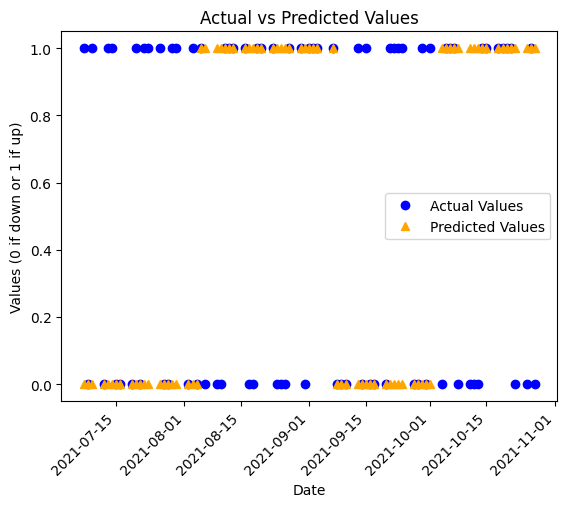

In [ ]:
print(pop.best_solution)
from sklearn.metrics import accuracy_score, confusion_matrix


def test_stock(dataset):
    scaler = MinMaxScaler(feature_range=(0,1))

    scaled_data = scaler.fit_transform(dataset)
    time_steps = 20

    sequences, labels = [], []
    for i in range(len(scaled_data) - time_steps):
      sequences.append(scaled_data[i: i + time_steps, :])
    seq = np.array(sequences)
    print(seq.shape)
    return np.array(sequences)

def generate_testing(pop1):
    sol = np.array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])
    indices_of_ones = np.where(sol == 1)[0]
    selected_columns = pop1.features.columns[indices_of_ones][7:14]
    if not selected_columns.all():
          return 0
    X = test_stock(pop1.testing.loc[:,selected_columns])
    print(X.shape)
    value_predicted = pop1.model.predict(X)
    actual_val = pop1.testing["Target"]
    index_values = pop1.testing.index

    # Line plot for actual values
    plt.plot(index_values[:80], actual_val[:80], label="Actual Values", marker='o',linestyle='None', color='blue')
    threshold = 0.5
    binary_predictions = (value_predicted >= threshold).astype(int)
    accuracy = accuracy_score(actual_val[:80], binary_predictions[:80])
    print(confusion_matrix(actual_val[:80],binary_predictions[:80] ))
    print("acruacy", accuracy)
    #conf_matrix = sklearn.metrics.confusion_matrix(actual_val, binary_predictions)
    # Line plot for predicted values
    plt.plot(index_values[:80], binary_predictions[:80], label="Predicted Values", linestyle='None',  marker='^', color='orange')
    plt.xticks(rotation=45, ha='right')
    plt.xlabel("Date")
    plt.ylabel("Values (0 if down or 1 if up)")
    plt.title("Actual vs Predicted Values")
    plt.legend()
    plt.show()

generate_testing(pop)

In [ ]:
import random
from datetime import datetime, timedelta
print(losses)
losses = [0.4, 0.7, 0.65, 0.7, 0.6]
plt.plot(range(1, (5) + 1), losses)
plt.title('Genetic Algorithm -LSTM Accuracy Curve')
plt.xlabel('Generation')
plt.ylabel('Accuracy')
plt.show()